## Prediction of MSFT stock price using LSTM

In [47]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import datetime as dt
%matplotlib inline

In [48]:
#reading the stock market data

#STEP 1: Pick any listed stock that you like ( the company should be listed for atleast 10+ years). 
#Using investpy, extract its 11 year closing values - From Jan 2010 to Dec 2020.

company = 'MSFT'
start = dt.datetime(2010,1,1)
end = dt.datetime(2020,12,1)
stock_data = pdr.DataReader(company,'yahoo',start,end)

In [49]:
#starting the dataset from Jan 2010
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,30.990000,30.480000,30.980000,30.480000,31929700.0,23.684755
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.049969
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.057743
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,23.910097
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.661432


In [50]:
#ending the dataset at Dec 2020
stock_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-24,214.250000,208.860001,209.589996,213.860001,33979700.0,213.368576
2020-11-25,215.289993,212.460007,215.110001,213.869995,21012900.0,213.378555
2020-11-27,216.270004,214.039993,214.850006,215.229996,14512200.0,214.735428
2020-11-30,214.759995,210.839996,214.100006,214.070007,33064800.0,213.578094
2020-12-01,217.320007,213.350006,214.509995,216.210007,30904500.0,215.713181


In [51]:
#only getting the closing value of the stock prices
stock_data = stock_data['Close']
stock_data.head()

Date
2009-12-31    30.480000
2010-01-04    30.950001
2010-01-05    30.959999
2010-01-06    30.770000
2010-01-07    30.450001
Name: Close, dtype: float64

In [52]:
stock_data=stock_data.to_frame()
stock_data

,Close
Date,
2009-12-31,30.480000
2010-01-04,30.950001
2010-01-05,30.959999
2010-01-06,30.770000
2010-01-07,30.450001
...,...
2020-11-24,213.860001
2020-11-25,213.869995
2020-11-27,215.229996


### Cleaning the dataset

In [53]:
#Cleaning the dataset
stock_data.dtypes

Close    float64
dtype: object

In [54]:
print(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2749 entries, 2009-12-31 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2749 non-null   float64
dtypes: float64(1)
memory usage: 43.0 KB
None


In [55]:
stock_data.shape

(2749, 1)

In [56]:
null_values=stock_data[stock_data.isna().any(axis=1)]
null_values

,Close
Date,


In [57]:
#this shows that dataset doesnot contain any null values
stock_data.describe()

,Close
count,2749.000000
mean,67.658669
std,49.901868
min,23.010000
25%,30.200001
50%,46.880001
75%,92.879997
max,231.649994


## Exploratory Data Analysis

Text(0, 0.5, 'Close')

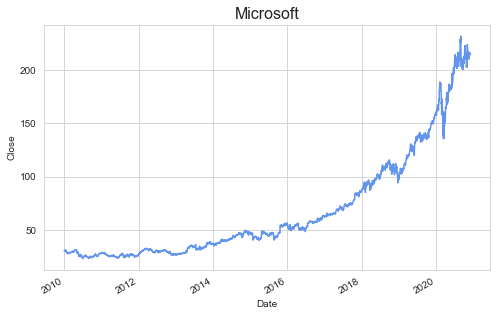

In [58]:
#Exploratpry Data Analysis
#seeing the historial view of closing price of MSFT

sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
stock_data['Close'].plot(color='cornflowerblue')
plt.title('Microsoft',fontsize=16)
plt.ylabel('Close')

In [59]:
#We'll use pct_change to find the percent change for each day
stock_data['Daily Return'] = stock_data['Close'].pct_change()
stock_data=stock_data.dropna()
stock_data.head()
#stock_data.shape
#null_values=stock_data[stock_data.isna().any(axis=1)]
#null_values

,Close,Daily Return
Date,,
2010-01-04,30.950001,0.015420
2010-01-05,30.959999,0.000323
2010-01-06,30.770000,-0.006137
2010-01-07,30.450001,-0.010400
2010-01-08,30.660000,0.006897


<AxesSubplot:xlabel='Date'>

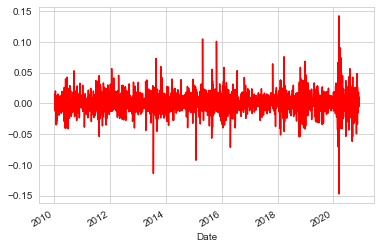

In [60]:
stock_data['Daily Return'].plot(color='r')

In [61]:
stock_data.head()
stock_data.shape

(2748, 2)

In [62]:
stock_data.pop('Daily Return')
stock_data.head()

,Close
Date,
2010-01-04,30.950001
2010-01-05,30.959999
2010-01-06,30.770000
2010-01-07,30.450001
2010-01-08,30.660000


## Model building(LSTM)

In [63]:
#Preparing data for LSTM 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_stock_data = scaler.fit_transform(np.array(stock_data).reshape(-1,1))
scaled_stock_data

array([[0.03805599],
       [0.03810391],
       [0.03719325],
       ...,
       [0.92129985],
       [0.91574009],
       [0.92599699]])

In [64]:
#how many days I want to base my predictions on
prediction_days=60
X_train=[]
y_train=[]
for x in range(prediction_days,len(scaled_stock_data)):
    X_train.append(scaled_stock_data[x-prediction_days:x, 0])
    y_train.append(scaled_stock_data[x,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2688, 60, 1)

In [65]:
#importing libraries for LSTM
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [66]:
#building the LSTM model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [67]:
#fitting the training data into the model
model.fit(X_train,y_train,epochs=25,batch_size=25)

Epoch 1/25
108/108 [==============================] - 25s 115ms/step - loss: 0.0068
Epoch 2/25
108/108 [==============================] - 11s 105ms/step - loss: 0.00143s - loss: 0. - ETA: 3s - loss -
Epoch 3/25
108/108 [==============================] - 12s 114ms/step - loss: 0.0013
Epoch 4/25
108/108 [==============================] - 11s 105ms/step - loss: 0.0013
Epoch 5/25
108/108 [==============================] - 10s 95ms/step - loss: 0.0010
Epoch 6/25
108/108 [==============================] - 9s 81ms/step - loss: 0.0012
Epoch 7/25
108/108 [==============================] - 11s 102ms/step - loss: 0.0011
Epoch 8/25
108/108 [==============================] - 11s 104ms/step - loss: 0.0011
Epoch 9/25
108/108 [==============================] - 12s 110ms/step - loss: 9.5611e-04
Epoch 10/25
108/108 [==============================] - 12s 109ms/step - loss: 9.8117e-044s - 
Epoch 11/25
108/108 [==============================] - 13s 117ms/step - loss: 8.3810e-04
Epoch 12/25
108/108 [=======

In [68]:
#providing the model with new data
test_start=dt.datetime(2020,1,1)
test_end=dt.datetime.now()

test_stock_data = pdr.DataReader(company,'yahoo',test_start,test_end)
test_stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,155.688324
2020-01-02,160.729996,158.330002,158.779999,160.619995,22622100.0,158.571075
2020-01-03,159.949997,158.059998,158.320007,158.619995,21116200.0,156.596588
2020-01-06,159.100006,156.509995,157.080002,159.029999,20813700.0,157.001373
2020-01-07,159.669998,157.320007,159.320007,157.580002,21634100.0,155.569855


In [76]:
#actual_prices is the prices of the actual data
actual_prices = test_stock_data['Close'].values
total_dataset = pd.concat((stock_data['Close'],test_stock_data['Close']),axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_stock_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

## Comparing Actual prices and Predicted prices

In [78]:
#making predictions
X_test=[]
for x in range(prediction_days,len(model_inputs)):
    X_test.append(model_inputs[x-prediction_days:x,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


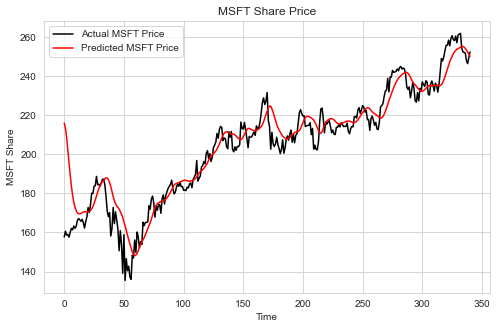

In [84]:
#plotting the actual and predicted prices
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
plt.plot(actual_prices,color='black',label=f'Actual {company} Price')
plt.plot(predicted_prices,color='r',label =f'Predicted {company} Price')
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share")
plt.legend()
plt.show()

## Predicting the stock price for the next day

In [93]:
#predicting next day price

data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs)+1,0]]
data = np.array(data)
data = np.reshape(data, (data.shape[0],data.shape[1],1))
next_day_prediction = model.predict(data)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"{company} Stock Price for the next day: {next_day_prediction}")

MSFT Stock Price for the next day: [[249.5767]]
